In [1]:
import sys

!{sys.executable} -m pip install -U --pre "mxnet>=1.7.0b20200713, <2.0.0" -f https://sxjscience.github.io/KDD2020/


Looking in links: https://sxjscience.github.io/KDD2020/
     |████████████████████████████████| 55.0MB 87kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
!{sys.executable} -m pip install autogluon

     |████████████████████████████████| 624kB 5.8MB/s 
     |████████████████████████████████| 215kB 16.7MB/s 
     |████████████████████████████████| 665kB 24.7MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 112kB 34.1MB/s 
     |████████████████████████████████| 66.3MB 61kB/s 
     |████████████████████████████████| 28.6MB 162kB/s 
     |████████████████████████████████| 133kB 39.7MB/s 
     |████████████████████████████████| 890kB 42.7MB/s 
     |████████████████████████████████| 819kB 37.1MB/s 
     |████████████████████████████████| 2.6MB 36.8MB/s 
     |████████████████████████████████| 153kB 49.3MB/s 
     |████████████████████████████████| 2.1MB 44.9MB/s 
     |████████████████████████████████| 1.8MB 41.2MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 962kB 43.8MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 7.0MB 45.2MB/s 

In [3]:
!{sys.executable} -m pip install bokeh==2.0.1

     |████████████████████████████████| 8.6MB 3.8MB/s 
  Created wheel for bokeh: filename=bokeh-2.0.1-cp36-none-any.whl size=9080030 sha256=26382566f350b05d52a345b169e561be498e291d5a460eebaf18b6b965b9a0b6
  Stored in directory: /root/.cache/pip/wheels/de/64/d0/e7f70919e19f57a6efceb65cc4edaa0449e707bcdb6e7e61ad
Successfully built bokeh
ERROR: panel 0.9.7 has requirement bokeh>=2.1, but you'll have bokeh 2.0.1 which is incompatible.
  Found existing installation: bokeh 2.1.1
    Uninstalling bokeh-2.1.1:
      Successfully uninstalled bokeh-2.1.1


AFTER RUN PRECEDING PIP INSTALLS (ETC), MUST RESTART RUNTIME (Runtime>>Restart Runtime)


In [1]:
import autogluon as ag
from autogluon import TabularPrediction as task

In [2]:
###READ IN DATA
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('seaborn-poster')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving TemperatureOverTimeByStation.csv to TemperatureOverTimeByStation.csv


In [4]:
import io
data = pd.read_csv(io.BytesIO(uploaded['TemperatureOverTimeByStation.csv']))

In [5]:
data.shape

(33865, 19)

In [6]:
data.head()

,Unnamed: 0,Hourstart,Temp_4847,Temp_94889,Temp_94847,Temp_94815,Temp_14833,Temp_14836,Temp_94860,Temp_4888,Temp_14826,Temp_14840,Temp_14845,Temp_94898,Temp_94894,Temp_14817,Temp_14850,Temp_94849,Temp_14841
0,1,2017-01-01 01:00:00,28.0,19.9,27.0,23.0,23.0,26.1,27.0,28.4,28.0,30.0,30.0,30.9,25.0,22.1,27.0,28.9,25.0
1,2,2017-01-01 02:00:00,26.1,19.0,26.1,25.0,23.0,24.1,24.1,28.4,28.0,25.0,28.0,30.0,24.1,21.6,26.1,26.1,28.0
2,3,2017-01-01 03:00:00,25.0,18.0,23.0,21.0,24.1,23.0,26.1,26.6,25.0,26.1,26.1,28.0,25.0,20.1,26.1,25.0,28.0
3,4,2017-01-01 04:00:00,24.1,19.9,24.1,26.1,24.1,23.0,24.1,24.8,25.0,30.0,25.0,28.0,24.1,19.4,27.0,24.1,28.0
4,5,2017-01-01 05:00:00,23.0,16.0,24.1,25.0,24.1,23.0,26.1,24.8,25.0,30.9,25.0,27.0,24.1,23.0,28.0,24.1,27.0


In [7]:
data=data.drop(['Unnamed: 0'],axis=1)
#Drop column added during R save


In [8]:
sorted_zipped_lists=sorted(zip(data.isna().sum(),list(data))) #sorts zipped lists by first list, which is the # of NA values for a given column

In [9]:
sorted_column_names = [element for _, element in sorted_zipped_lists]
sorted_column_names.remove('Hourstart') #remove Hourstart from list, because we don't need to impute any missing values for this variable

In [11]:
#Create a dataframe with WeatherStation-specific values for the initial missing values 
#(later, we'll use this to evaluate the link between missingness and confidence in our imputed values)
Comparison_Frame = pd.DataFrame(sorted_zipped_lists)
Comparison_Frame.rename(columns={0:"missing_values",1:"Station"},inplace=True)
Comparison_Frame.drop(Comparison_Frame.index[0],inplace=True)
Comparison_Frame = Comparison_Frame[['Station','missing_values']]

In [12]:
time_limits = 5 * 60 # train various models for ~5 min

performances=[]
all_results=[]

#Loop through each weather station in 'sorted_column_names' (ascending in terms of the N of missing observations, so we leave the largest imputation for the most complete dataset)
#AND impute missing values, then move to next station
for LC in sorted_column_names:
    label_column = LC
    print(label_column)
    nomissings=data.dropna(subset=[label_column]) #drop rows with missing values for the given column
    train = nomissings.sample(frac=0.75, random_state=99)
    # you can't simply split 0.75 and 0.25 without overlapping
    # this code tries to find that train = 75% and test = 25%
    test = nomissings.loc[~nomissings.index.isin(train.index), :]

    #use R2 as evaluation metric
    predictor = task.fit(train_data=train, tuning_data=test,
                        label=label_column,
                        time_limits = time_limits,
                        eval_metric = "r2")

    #performance of best model (or ensemble)
    performance = predictor.evaluate(test)

    #append performance metric/info to 'performances' list
    performances.append(performance)

    #overall results (i.e. all different models)
    results = predictor.fit_summary()

    #append results table/info to 'all_results' list
    all_results.append(results)

    missers = data.loc[~data.index.isin(nomissings.index), :] 
    print(missers.shape)
    #from the *data* df, pull those rows that 
    #weren't included once we dropped rows that were missing values for the given column
    predicted_missingvalues = predictor.predict(missers)

    missers[label_column]=predicted_missingvalues #plug-in interpreted values, obtained from autogluon

    combined=nomissings.append(missers)
    #recombine missers with nonmissers, creating a more robust dataset to model downstream analyses

    data = combined #define 'new' dataframe (data) with imputed values included

NumExpr defaulting to 2 threads.
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_211545/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_211545/
AutoGluon Version:  0.0.14
Train Data Rows:    25396
Train Data Columns: 17
Tuning Data Rows:    8466
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (93.9, -9.9, 50.1799, 19.74923)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12716.89 MB
	Train Data (Original)  Memory Usage: 6.91 MB (0.1% of availab

Temp_94860


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.61 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.73s ...
AutoGluon will gauge 

[1000]	train_set's l2: 0.666801	train_set's r2: 0.998089	valid_set's l2: 2.15408	valid_set's r2: 0.9944


	0.9946	 = Validation r2 score
	8.12s	 = Training runtime
	0.67s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 196.35s of the 196.35s of remaining time.


[1000]	train_set's l2: 1.65661	train_set's r2: 0.995526	valid_set's l2: 2.403	valid_set's r2: 0.993779
[2000]	train_set's l2: 1.24319	train_set's r2: 0.996597	valid_set's l2: 2.27566	valid_set's r2: 0.994107


	0.9943	 = Validation r2 score
	15.7s	 = Training runtime
	2.38s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 177.72s of the 177.72s of remaining time.
	0.9948	 = Validation r2 score
	50.54s	 = Training runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 127.1s of the 127.1s of remaining time.
	Ran out of time, stopping training early.
	0.9936	 = Validation r2 score
	129.22s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.27s of the -10.4s of remaining time.
	0.9951	 = Validation r2 score
	0.55s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 311.0s ...


Predictive performance on given dataset: r2 = 0.9950691990849542
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.995069       4.609976   98.700340                0.001230           0.551464            1       True          9
1         CatboostRegressor   0.994839       0.047252   50.537537                0.047252          50.537537            0       True          7
2         LightGBMRegressor   0.994587       0.666490    8.121783                0.666490           8.121783            0       True          5
3    ExtraTreesRegressorMSE   0.994366       0.605745   23.702057                0.605745          23.702057            0       True          2
4       LightGBMRegressorXT   0.994301       2.380141   15.703543                2.380141          15.703543            0       True          6
5  Random

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_212105/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_212105/
AutoGluon Version:  0.0.14
Train Data Rows:    25363
Train Data Columns: 17
Tuning Data Rows:    8454
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (96.1, -13.0, 51.9586, 19.63998)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_94847


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.5s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.61s ...
AutoGluon will gauge p

[1000]	train_set's l2: 0.634099	train_set's r2: 0.998148	valid_set's l2: 2.16592	valid_set's r2: 0.994219


	0.9945	 = Validation r2 score
	9.51s	 = Training runtime
	0.86s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 200.12s of the 200.11s of remaining time.


[1000]	train_set's l2: 1.73704	train_set's r2: 0.995277	valid_set's l2: 2.5442	valid_set's r2: 0.993248


	0.9936	 = Validation r2 score
	9.84s	 = Training runtime
	1.53s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 188.41s of the 188.41s of remaining time.
	0.9947	 = Validation r2 score
	61.41s	 = Training runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 126.92s of the 126.91s of remaining time.
	Ran out of time, stopping training early.
	0.9927	 = Validation r2 score
	128.56s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.39s of the -9.17s of remaining time.
	0.9949	 = Validation r2 score
	0.54s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 309.76s ...


Predictive performance on given dataset: r2 = 0.9949228140237195
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.994923       1.823598   71.518276                0.000803           0.537533            1       True          9
1         CatboostRegressor   0.994676       0.052639   61.405389                0.052639          61.405389            0       True          7
2         LightGBMRegressor   0.994501       0.861212    9.510396                0.861212           9.510396            0       True          5
3       LightGBMRegressorXT   0.993624       1.526091    9.843555                1.526091           9.843555            0       True          6
4    ExtraTreesRegressorMSE   0.993475       0.605387   23.391493                0.605387          23.391493            0       True          2
5  Random

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_212619/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_212619/
AutoGluon Version:  0.0.14
Train Data Rows:    25360
Train Data Columns: 17
Tuning Data Rows:    8453
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (95.0, -11.0, 49.3537, 19.90164)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_14845


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.8s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.82s ...
AutoGluon will gauge p

[1000]	train_set's l2: 0.849125	train_set's r2: 0.997649	valid_set's l2: 2.78368	valid_set's r2: 0.992831


	0.9933	 = Validation r2 score
	10.77s	 = Training runtime
	1.12s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 201.07s of the 201.07s of remaining time.


[1000]	train_set's l2: 2.27876	train_set's r2: 0.994029	valid_set's l2: 3.23821	valid_set's r2: 0.991659


	0.9921	 = Validation r2 score
	10.25s	 = Training runtime
	1.66s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 188.8s of the 188.8s of remaining time.
	0.9934	 = Validation r2 score
	52.42s	 = Training runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 136.31s of the 136.3s of remaining time.
	Ran out of time, stopping training early.
	0.9912	 = Validation r2 score
	137.86s	 = Training runtime
	0.22s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.18s of the -9.51s of remaining time.
	0.9938	 = Validation r2 score
	0.55s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 310.1s ...


Predictive performance on given dataset: r2 = 0.9938261537933146
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.993826       2.078957   63.806242                0.000872           0.545183            1       True          9
1         CatboostRegressor   0.993350       0.047328   52.415716                0.047328          52.415716            0       True          7
2         LightGBMRegressor   0.993277       1.122127   10.767365                1.122127          10.767365            0       True          5
3    ExtraTreesRegressorMSE   0.992587       0.605660   22.570133                0.605660          22.570133            0       True          2
4   KNeighborsRegressorDist   0.992205       0.908631    0.077978                0.908631           0.077978            0       True          4
5       L

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_213133/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_213133/
AutoGluon Version:  0.0.14
Train Data Rows:    25357
Train Data Columns: 17
Tuning Data Rows:    8452
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (98.1, -24.0, 45.48159, 20.02738)
	If 'regression' is not the correct problem_type, please manually specify 

Temp_94849


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.76s ...
AutoGluon will gauge p

[1000]	train_set's l2: 1.79783	train_set's r2: 0.995293	valid_set's l2: 6.23185	valid_set's r2: 0.984321


	0.9855	 = Validation r2 score
	14.44s	 = Training runtime
	1.57s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 190.95s of the 190.94s of remaining time.


[1000]	train_set's l2: 5.14893	train_set's r2: 0.986952	valid_set's l2: 7.48157	valid_set's r2: 0.98104
[2000]	train_set's l2: 3.8477	train_set's r2: 0.990196	valid_set's l2: 6.91092	valid_set's r2: 0.982556


	0.9828	 = Validation r2 score
	15.01s	 = Training runtime
	2.68s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 172.71s of the 172.71s of remaining time.
	0.986	 = Validation r2 score
	86.66s	 = Training runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 85.93s of the 85.93s of remaining time.
	Ran out of time, stopping training early.
	0.9784	 = Validation r2 score
	88.49s	 = Training runtime
	0.23s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.23s of the -12.26s of remaining time.
	0.9867	 = Validation r2 score
	0.55s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 312.85s ...


Predictive performance on given dataset: r2 = 0.9866951252005556
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.986695       2.552105  101.717181                0.000837           0.549051            1       True          9
1         CatboostRegressor   0.985973       0.073724   86.660106                0.073724          86.660106            0       True          7
2         LightGBMRegressor   0.985471       1.567322   14.440609                1.567322          14.440609            0       True          5
3    ExtraTreesRegressorMSE   0.984081       0.705737   23.674490                0.705737          23.674490            0       True          2
4  RandomForestRegressorMSE   0.983170       0.505287   55.954456                0.505287          55.954456            0       True          1
5   KNeig

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_213651/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_213651/
AutoGluon Version:  0.0.14
Train Data Rows:    25356
Train Data Columns: 17
Tuning Data Rows:    8452
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (96.1, -27.9, 44.45413, 20.55891)
	If 'regression' is not the correct problem_type, please manually specify 

Temp_14841


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.8s ...
AutoGluon will gauge pr

[1000]	train_set's l2: 2.27404	train_set's r2: 0.994433	valid_set's l2: 6.95376	valid_set's r2: 0.983423
[2000]	train_set's l2: 0.916699	train_set's r2: 0.997643	valid_set's l2: 6.44614	valid_set's r2: 0.984676


	0.9848	 = Validation r2 score
	15.56s	 = Training runtime
	1.67s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 189.25s of the 189.25s of remaining time.


[1000]	train_set's l2: 6.5317	train_set's r2: 0.984379	valid_set's l2: 8.95568	valid_set's r2: 0.978662
[2000]	train_set's l2: 4.90456	train_set's r2: 0.988199	valid_set's l2: 8.12943	valid_set's r2: 0.980619


	0.9816	 = Validation r2 score
	20.55s	 = Training runtime
	3.56s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 164.42s of the 164.42s of remaining time.
	0.9852	 = Validation r2 score
	93.42s	 = Training runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 70.86s of the 70.86s of remaining time.
	Ran out of time, stopping training early.
	0.9738	 = Validation r2 score
	73.52s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.2s of the -13.4s of remaining time.
	0.9861	 = Validation r2 score
	0.54s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 313.98s ...


Predictive performance on given dataset: r2 = 0.9861048351007989
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.986105       2.663287  109.593850                0.000884           0.540132            1       True          9
1         CatboostRegressor   0.985193       0.083017   93.424906                0.083017          93.424906            0       True          7
2         LightGBMRegressor   0.984807       1.670482   15.555847                1.670482          15.555847            0       True          5
3    ExtraTreesRegressorMSE   0.981751       0.705585   24.297050                0.705585          24.297050            0       True          2
4   KNeighborsRegressorDist   0.981631       0.908905    0.072965                0.908905           0.072965            0       True          4
5       L

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_214209/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_214209/
AutoGluon Version:  0.0.14
Train Data Rows:    25354
Train Data Columns: 17
Tuning Data Rows:    8451
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (95.0, -17.0, 51.19213, 19.87811)
	If 'regression' is not the correct problem_type, please manually specify 

Temp_94815


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_14833', 'Temp_14836', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_14833', 'Temp_14836', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.6s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.68s ...
AutoGluon will gauge p

[1000]	train_set's l2: 0.939519	train_set's r2: 0.997421	valid_set's l2: 2.83549	valid_set's r2: 0.992765


	0.993	 = Validation r2 score
	9.57s	 = Training runtime
	0.9s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 199.87s of the 199.87s of remaining time.


[1000]	train_set's l2: 2.52674	train_set's r2: 0.993385	valid_set's l2: 3.35179	valid_set's r2: 0.991402


	0.9919	 = Validation r2 score
	10.68s	 = Training runtime
	1.66s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 187.14s of the 187.14s of remaining time.
	0.9934	 = Validation r2 score
	67.35s	 = Training runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 119.69s of the 119.69s of remaining time.
	Ran out of time, stopping training early.
	0.9912	 = Validation r2 score
	120.5s	 = Training runtime
	0.22s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.32s of the -15.45s of remaining time.
	0.9938	 = Validation r2 score
	0.55s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 316.04s ...


Predictive performance on given dataset: r2 = 0.9937713415674656
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.993771       1.869465   77.541825                0.000758           0.547574            1       True          9
1         CatboostRegressor   0.993364       0.058995   67.352317                0.058995          67.352317            0       True          7
2         LightGBMRegressor   0.993030       0.901112    9.568205                0.901112           9.568205            0       True          5
3    ExtraTreesRegressorMSE   0.992492       0.705451   23.304131                0.705451          23.304131            0       True          2
4  RandomForestRegressorMSE   0.991969       0.605536   53.950096                0.605536          53.950096            0       True          1
5   KNeig

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_214729/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_214729/
AutoGluon Version:  0.0.14
Train Data Rows:    25353
Train Data Columns: 17
Tuning Data Rows:    8451
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (97.0, -8.0, 47.97853, 19.66159)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_14850


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.79s ...
AutoGluon will gauge p

[1000]	train_set's l2: 1.119	train_set's r2: 0.996875	valid_set's l2: 4.01458	valid_set's r2: 0.989635


	0.9903	 = Validation r2 score
	13.47s	 = Training runtime
	1.54s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 194.33s of the 194.32s of remaining time.


[1000]	train_set's l2: 3.3592	train_set's r2: 0.991097	valid_set's l2: 4.7849	valid_set's r2: 0.987653


	0.9884	 = Validation r2 score
	10.83s	 = Training runtime
	1.9s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 181.19s of the 181.19s of remaining time.
	0.9907	 = Validation r2 score
	88.95s	 = Training runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 92.11s of the 92.11s of remaining time.
	Ran out of time, stopping training early.
	0.986	 = Validation r2 score
	93.89s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.21s of the -17.35s of remaining time.
	0.9912	 = Validation r2 score
	0.55s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 317.93s ...


Predictive performance on given dataset: r2 = 0.9912254972816404
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.991225       2.521263  103.042037                0.000784           0.546377            1       True          9
1         CatboostRegressor   0.990721       0.075160   88.954810                0.075160          88.954810            0       True          7
2         LightGBMRegressor   0.990289       1.536143   13.473293                1.536143          13.473293            0       True          5
3    ExtraTreesRegressorMSE   0.988998       0.605179   23.093556                0.605179          23.093556            0       True          2
4   KNeighborsRegressorDist   0.988642       0.909176    0.067557                0.909176           0.067557            0       True          4
5       L

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_215252/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_215252/
AutoGluon Version:  0.0.14
Train Data Rows:    25350
Train Data Columns: 17
Tuning Data Rows:    8450
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (97.0, -16.1, 49.83175, 19.94201)
	If 'regression' is not the correct problem_type, please manually specify 

Temp_14826


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.72s ...
AutoGluon will gauge p

[1000]	train_set's l2: 0.749702	train_set's r2: 0.997914	valid_set's l2: 2.36465	valid_set's r2: 0.994018


	0.9944	 = Validation r2 score
	12.09s	 = Training runtime
	1.37s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 200.18s of the 200.17s of remaining time.


[1000]	train_set's l2: 1.89699	train_set's r2: 0.995023	valid_set's l2: 2.72467	valid_set's r2: 0.993105


	0.9935	 = Validation r2 score
	9.49s	 = Training runtime
	1.6s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 188.76s of the 188.75s of remaining time.
	0.9945	 = Validation r2 score
	58.09s	 = Training runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 130.58s of the 130.58s of remaining time.
	Ran out of time, stopping training early.
	0.9924	 = Validation r2 score
	131.8s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.28s of the -16.53s of remaining time.
	0.9948	 = Validation r2 score
	0.56s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 317.13s ...


Predictive performance on given dataset: r2 = 0.9947556362418368
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.994756       2.934171   93.395292                0.000891           0.558287            1       True          9
1         CatboostRegressor   0.994529       0.050678   58.089478                0.050678          58.089478            0       True          7
2         LightGBMRegressor   0.994369       1.368309   12.089037                1.368309          12.089037            0       True          5
3    ExtraTreesRegressorMSE   0.993649       0.605905   22.589720                0.605905          22.589720            0       True          2
4       LightGBMRegressorXT   0.993456       1.598480    9.491168                1.598480           9.491168            0       True          6
5  Random

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_215816/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_215816/
AutoGluon Version:  0.0.14
Train Data Rows:    25345
Train Data Columns: 17
Tuning Data Rows:    8448
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (95.0, -12.0, 50.39676, 18.95486)
	If 'regression' is not the correct problem_type, please manually specify the p

Temp_14840


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.6 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.79s ...
AutoGluon will gauge p

[1000]	train_set's l2: 1.19672	train_set's r2: 0.99644	valid_set's l2: 3.9559	valid_set's r2: 0.989025
[2000]	train_set's l2: 0.491169	train_set's r2: 0.998427	valid_set's l2: 3.73092	valid_set's r2: 0.989571


	0.9899	 = Validation r2 score
	15.17s	 = Training runtime
	1.77s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 190.94s of the 190.94s of remaining time.


[1000]	train_set's l2: 3.42068	train_set's r2: 0.990258	valid_set's l2: 4.71886	valid_set's r2: 0.986947


	0.9879	 = Validation r2 score
	12.42s	 = Training runtime
	2.15s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 175.91s of the 175.91s of remaining time.
	0.9899	 = Validation r2 score
	74.91s	 = Training runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 100.9s of the 100.9s of remaining time.
	Ran out of time, stopping training early.
	0.9847	 = Validation r2 score
	102.64s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.21s of the -18.31s of remaining time.
	0.9904	 = Validation r2 score
	0.56s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 318.91s ...


Predictive performance on given dataset: r2 = 0.9904131665317104
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.990413       2.746584   90.710118                0.000793           0.562701            1       True          9
1         CatboostRegressor   0.989890       0.063931   74.908818                0.063931          74.908818            0       True          7
2         LightGBMRegressor   0.989862       1.773129   15.169518                1.773129          15.169518            0       True          5
3       LightGBMRegressorXT   0.987899       2.147560   12.423695                2.147560          12.423695            0       True          6
4    ExtraTreesRegressorMSE   0.987198       0.605424   23.602549                0.605424          23.602549            0       True          2
5  Random

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_220340/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_220340/
AutoGluon Version:  0.0.14
Train Data Rows:    25338
Train Data Columns: 17
Tuning Data Rows:    8446
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (95.0, -13.5, 49.7669, 20.00766)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_14836


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.6s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.59 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.66s ...
AutoGluon will gauge 

[1000]	train_set's l2: 0.554857	train_set's r2: 0.998411	valid_set's l2: 1.78265	valid_set's r2: 0.995414


	0.9957	 = Validation r2 score
	10.2s	 = Training runtime
	1.07s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 202.28s of the 202.27s of remaining time.


[1000]	train_set's l2: 1.42965	train_set's r2: 0.996234	valid_set's l2: 2.04941	valid_set's r2: 0.994778


	0.9952	 = Validation r2 score
	12.04s	 = Training runtime
	2.06s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 187.74s of the 187.74s of remaining time.
	0.9957	 = Validation r2 score
	33.68s	 = Training runtime
	0.03s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 153.99s of the 153.99s of remaining time.
	Ran out of time, stopping training early.
	0.9949	 = Validation r2 score
	156.57s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.34s of the -17.12s of remaining time.
	0.996	 = Validation r2 score
	0.55s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 317.72s ...


Predictive performance on given dataset: r2 = 0.9959834600569324
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.995983       2.831779  223.564642                0.001061           0.546083            1       True          9
1         CatboostRegressor   0.995721       0.033515   33.684086                0.033515          33.684086            0       True          7
2         LightGBMRegressor   0.995691       1.069325   10.195570                1.069325          10.195570            0       True          5
3    ExtraTreesRegressorMSE   0.995394       0.605235   22.501669                0.605235          22.501669            0       True          2
4  RandomForestRegressorMSE   0.995197       0.505296   51.867584                0.505296          51.867584            0       True          1
5       L

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_220905/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_220905/
AutoGluon Version:  0.0.14
Train Data Rows:    25331
Train Data Columns: 17
Tuning Data Rows:    8444
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (95.0, -16.0, 50.17034, 19.72644)
	If 'regression' is not the correct problem_type, please manually specify 

Temp_14833


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14836', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14836', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.59 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.8s ...
AutoGluon will gauge p

[1000]	train_set's l2: 0.695863	train_set's r2: 0.998025	valid_set's l2: 2.27729	valid_set's r2: 0.994083


	0.9943	 = Validation r2 score
	8.52s	 = Training runtime
	0.9s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 203.15s of the 203.15s of remaining time.


[1000]	train_set's l2: 1.76876	train_set's r2: 0.995223	valid_set's l2: 2.54275	valid_set's r2: 0.993369


	0.9936	 = Validation r2 score
	8.59s	 = Training runtime
	1.47s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 192.79s of the 192.79s of remaining time.
	0.9944	 = Validation r2 score
	55.71s	 = Training runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 137.0s of the 137.0s of remaining time.
	Ran out of time, stopping training early.
	0.9933	 = Validation r2 score
	139.18s	 = Training runtime
	0.22s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.2s of the -17.12s of remaining time.
	0.9947	 = Validation r2 score
	0.55s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 317.71s ...


Predictive performance on given dataset: r2 = 0.9946685183838353
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.994669       2.085111  204.032509                0.000805           0.550006            1       True          9
1         CatboostRegressor   0.994418       0.049756   55.709610                0.049756          55.709610            0       True          7
2         LightGBMRegressor   0.994257       0.901373    8.516882                0.901373           8.516882            0       True          5
3    ExtraTreesRegressorMSE   0.993792       0.605283   22.597534                0.605283          22.597534            0       True          2
4       LightGBMRegressorXT   0.993622       1.469902    8.588310                1.469902           8.588310            0       True          6
5  Random

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_221438/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_221438/
AutoGluon Version:  0.0.14
Train Data Rows:    25326
Train Data Columns: 17
Tuning Data Rows:    8442
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (93.9, -19.0, 50.21239, 19.75756)
	If 'regression' is not the correct problem_type, please manually specify 

Temp_4847


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.59 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.76s ...
AutoGluon will gaug

[1000]	train_set's l2: 0.74981	train_set's r2: 0.997864	valid_set's l2: 2.52684	valid_set's r2: 0.993391


	0.9937	 = Validation r2 score
	9.15s	 = Training runtime
	0.91s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 198.86s of the 198.86s of remaining time.


[1000]	train_set's l2: 2.10608	train_set's r2: 0.994377	valid_set's l2: 3.10729	valid_set's r2: 0.991955


	0.9926	 = Validation r2 score
	12.8s	 = Training runtime
	2.26s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 183.34s of the 183.33s of remaining time.
	0.9939	 = Validation r2 score
	58.75s	 = Training runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 124.47s of the 124.47s of remaining time.
	Ran out of time, stopping training early.
	0.9912	 = Validation r2 score
	126.66s	 = Training runtime
	0.32s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.24s of the -10.88s of remaining time.
	0.9942	 = Validation r2 score
	0.56s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 311.49s ...


Predictive performance on given dataset: r2 = 0.9941995450549096
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.994200       1.875808   68.534834                0.000764           0.555578            1       True          9
1         CatboostRegressor   0.993944       0.056740   58.753834                0.056740          58.753834            0       True          7
2         LightGBMRegressor   0.993693       0.909372    9.150261                0.909372           9.150261            0       True          5
3       LightGBMRegressorXT   0.992589       2.264380   12.797702                2.264380          12.797702            0       True          6
4    ExtraTreesRegressorMSE   0.992454       0.705776   23.681132                0.705776          23.681132            0       True          2
5   KNeig

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_221953/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_221953/
AutoGluon Version:  0.0.14
Train Data Rows:    25313
Train Data Columns: 17
Tuning Data Rows:    8438
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (95.0, -22.8, 45.35193, 20.67177)
	If 'regression' is not the correct problem_type, please manually specify the p

Temp_14817


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.6s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.59 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.69s ...
AutoGluon will gauge 

[1000]	train_set's l2: 3.67283	train_set's r2: 0.991231	valid_set's l2: 4.8811	valid_set's r2: 0.988516
[2000]	train_set's l2: 2.78404	train_set's r2: 0.993271	valid_set's l2: 4.48218	valid_set's r2: 0.989444


	0.9899	 = Validation r2 score
	17.93s	 = Training runtime
	3.46s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 176.95s of the 176.95s of remaining time.
	0.9917	 = Validation r2 score
	98.12s	 = Training runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 78.69s of the 78.69s of remaining time.
	Ran out of time, stopping training early.
	0.9869	 = Validation r2 score
	80.02s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.31s of the -20.9s of remaining time.
	0.9919	 = Validation r2 score
	0.54s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 321.5s ...


Predictive performance on given dataset: r2 = 0.9918921877343257
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.991892       1.476833  105.435687                0.000808           0.544890            1       True          9
1         CatboostRegressor   0.991677       0.086849   98.122491                0.086849          98.122491            0       True          7
2         LightGBMRegressor   0.990705       0.574918    6.693564                0.574918           6.693564            0       True          5
3       LightGBMRegressorXT   0.989944       3.461531   17.933611                3.461531          17.933611            0       True          6
4    ExtraTreesRegressorMSE   0.989677       0.705883   24.826763                0.705883          24.826763            0       True          2
5   KNeig

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_222535/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_222535/
AutoGluon Version:  0.0.14
Train Data Rows:    25222
Train Data Columns: 17
Tuning Data Rows:    8408
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (94.5, -18.4, 48.59139, 19.24161)
	If 'regression' is not the correct problem_type, please manually specify 

Temp_4888


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.57 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.78s ...
AutoGluon will gauge 

[1000]	train_set's l2: 1.59512	train_set's r2: 0.995455	valid_set's l2: 4.96521	valid_set's r2: 0.986444


	0.9873	 = Validation r2 score
	11.59s	 = Training runtime
	1.36s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 196.59s of the 196.59s of remaining time.


[1000]	train_set's l2: 4.86166	train_set's r2: 0.986662	valid_set's l2: 6.31494	valid_set's r2: 0.982933
[2000]	train_set's l2: 3.67891	train_set's r2: 0.989823	valid_set's l2: 5.76599	valid_set's r2: 0.984334


	0.9849	 = Validation r2 score
	15.65s	 = Training runtime
	3.0s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 177.22s of the 177.22s of remaining time.
	0.9875	 = Validation r2 score
	71.57s	 = Training runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 105.54s of the 105.54s of remaining time.
	Ran out of time, stopping training early.
	0.9815	 = Validation r2 score
	106.53s	 = Training runtime
	0.22s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.22s of the -10.99s of remaining time.
	0.9883	 = Validation r2 score
	0.55s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 311.59s ...


Predictive performance on given dataset: r2 = 0.9882534378809726
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.988253       2.230662   83.782442                0.000990           0.554264            1       True          9
1         CatboostRegressor   0.987506       0.063966   71.569037                0.063966          71.569037            0       True          7
2         LightGBMRegressor   0.987300       1.356785   11.587421                1.356785          11.587421            0       True          5
3       LightGBMRegressorXT   0.984870       2.997350   15.651888                2.997350          15.651888            0       True          6
4    ExtraTreesRegressorMSE   0.984277       0.605478   23.452443                0.605478          23.452443            0       True          2
5   KNeig

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_223051/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_223051/
AutoGluon Version:  0.0.14
Train Data Rows:    25168
Train Data Columns: 17
Tuning Data Rows:    8390
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (93.0, -18.0, 49.44284, 19.81979)
	If 'regression' is not the correct problem_type, please manually specify 

Temp_94889


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94847', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94847', 'Temp_94815', 'Temp_14833', 'Temp_14836', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.6s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.56 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.66s ...
AutoGluon will gauge 

[1000]	train_set's l2: 3.03463	train_set's r2: 0.992081	valid_set's l2: 3.94755	valid_set's r2: 0.989793


	0.99	 = Validation r2 score
	7.08s	 = Training runtime
	1.18s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 195.17s of the 195.17s of remaining time.
	0.9918	 = Validation r2 score
	50.16s	 = Training runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 144.93s of the 144.92s of remaining time.
	Ran out of time, stopping training early.
	0.9899	 = Validation r2 score
	147.25s	 = Training runtime
	0.22s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.34s of the -9.49s of remaining time.
	0.9922	 = Validation r2 score
	0.56s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 310.09s ...


Predictive performance on given dataset: r2 = 0.9921968769080984
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.992197       1.531898  204.195099                0.000879           0.559644            1       True          9
1         CatboostRegressor   0.991824       0.045578   50.161924                0.045578          50.161924            0       True          7
2         LightGBMRegressor   0.991455       0.459831    6.161547                0.459831           6.161547            0       True          5
3    ExtraTreesRegressorMSE   0.990348       0.605348   22.968966                0.605348          22.968966            0       True          2
4       LightGBMRegressorXT   0.989992       1.178691    7.077241                1.178691           7.077241            0       True          6
5  Random

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_223605/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_223605/
AutoGluon Version:  0.0.14
Train Data Rows:    25037
Train Data Columns: 17
Tuning Data Rows:    8346
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (93.9, -5.0, 48.12986, 18.20073)
	If 'regression' is not the correct problem_type, please manually specify t

Temp_94898


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.54 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.79s ...
AutoGluon will gauge 

[1000]	train_set's l2: 1.934	train_set's r2: 0.993887	valid_set's l2: 7.2539	valid_set's r2: 0.978158
[2000]	train_set's l2: 0.764806	train_set's r2: 0.997458	valid_set's l2: 6.80009	valid_set's r2: 0.979496


	0.9798	 = Validation r2 score
	14.95s	 = Training runtime
	1.82s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 192.55s of the 192.55s of remaining time.


[1000]	train_set's l2: 6.90704	train_set's r2: 0.9789	valid_set's l2: 9.66511	valid_set's r2: 0.971038


	0.9735	 = Validation r2 score
	13.57s	 = Training runtime
	2.59s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 175.84s of the 175.84s of remaining time.
	0.98	 = Validation r2 score
	90.01s	 = Training runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 85.7s of the 85.7s of remaining time.
	Ran out of time, stopping training early.
	0.9621	 = Validation r2 score
	87.27s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.21s of the -18.01s of remaining time.
	0.981	 = Validation r2 score
	0.55s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 318.6s ...


Predictive performance on given dataset: r2 = 0.9809910182820382
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.980991       2.709215  105.576504                0.000795           0.548889            1       True          9
1         CatboostRegressor   0.980026       0.074956   90.013978                0.074956          90.013978            0       True          7
2         LightGBMRegressor   0.979828       1.824921   14.947335                1.824921          14.947335            0       True          5
3       LightGBMRegressorXT   0.973498       2.594941   13.567062                2.594941          13.567062            0       True          6
4  RandomForestRegressorMSE   0.972560       0.505151   55.146527                0.505151          55.146527            0       True          1
5    Extr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No output_directory specified. Models will be saved in: AutogluonModels/ag-20201202_224141/
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to AutogluonModels/ag-20201202_224141/
AutoGluon Version:  0.0.14
Train Data Rows:    25022
Train Data Columns: 17
Tuning Data Rows:    8340
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (91.9, -10.0, 46.73924, 18.90105)
	If 'regression' is not the correct problem_type, please manually specify 

Temp_94894


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])                      : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('object', ['datetime_as_object']) :  1 | ['Hourstart']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])                : 16 | ['Temp_4847', 'Temp_94889', 'Temp_94847', 'Temp_94815', 'Temp_14833', ...]
		('int', ['datetime_as_int']) :  1 | ['Hourstart']
	3.7s = Fit runtime
	17 features in original data used to generate 17 features in processed data.
	Train Data (Processed) Memory Usage: 4.54 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 3.73s ...
AutoGluon will gauge 

[1000]	train_set's l2: 1.43649	train_set's r2: 0.995761	valid_set's l2: 4.49548	valid_set's r2: 0.987388


	0.9881	 = Validation r2 score
	12.21s	 = Training runtime
	1.33s	 = Validation runtime
Fitting model: LightGBMRegressorXT ... Training model for up to 193.85s of the 193.85s of remaining time.


[1000]	train_set's l2: 4.86678	train_set's r2: 0.98618	valid_set's l2: 6.00622	valid_set's r2: 0.983122
[2000]	train_set's l2: 3.76564	train_set's r2: 0.98923	valid_set's l2: 5.45818	valid_set's r2: 0.984781


	0.9854	 = Validation r2 score
	17.43s	 = Training runtime
	3.46s	 = Validation runtime
Fitting model: CatboostRegressor ... Training model for up to 172.29s of the 172.29s of remaining time.
	0.988	 = Validation r2 score
	79.08s	 = Training runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetRegressor ... Training model for up to 93.09s of the 93.09s of remaining time.
	Ran out of time, stopping training early.
	0.9804	 = Validation r2 score
	94.02s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 296.27s of the -11.01s of remaining time.
	0.9887	 = Validation r2 score
	0.53s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 311.59s ...


Predictive performance on given dataset: r2 = 0.9887339235091487
*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1   0.988734       2.206545  91.899798                0.000780           0.534211            1       True          9
1         LightGBMRegressor   0.988087       1.329485  12.211261                1.329485          12.211261            0       True          5
2         CatboostRegressor   0.987963       0.067226  79.083926                0.067226          79.083926            0       True          7
3       LightGBMRegressorXT   0.985442       3.456533  17.428406                3.456533          17.428406            0       True          6
4    ExtraTreesRegressorMSE   0.985115       0.706235  23.501934                0.706235          23.501934            0       True          2
5  RandomForest

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
data.isna().sum() # check that we have no more missing values

Hourstart     0
Temp_4847     0
Temp_94889    0
Temp_94847    0
Temp_94815    0
Temp_14833    0
Temp_14836    0
Temp_94860    0
Temp_4888     0
Temp_14826    0
Temp_14840    0
Temp_14845    0
Temp_94898    0
Temp_94894    0
Temp_14817    0
Temp_14850    0
Temp_94849    0
Temp_14841    0
dtype: int64

In [14]:
data.to_csv('Weather_imputed.csv') 
files.download("Weather_imputed.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
Comparison_Frame['Rsq']=performances
Comparison_Frame

,Station,missing_values,Rsq
1,Temp_94860,3,0.995069
2,Temp_94847,48,0.994923
3,Temp_14845,52,0.993826
4,Temp_94849,56,0.986695
5,Temp_14841,57,0.986105
6,Temp_94815,60,0.993771
7,Temp_14850,61,0.991225
8,Temp_14826,65,0.994756
9,Temp_14840,72,0.990413
10,Temp_14836,81,0.995983


In [16]:
# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b


best fit line:
y = 0.99 + -0.00x


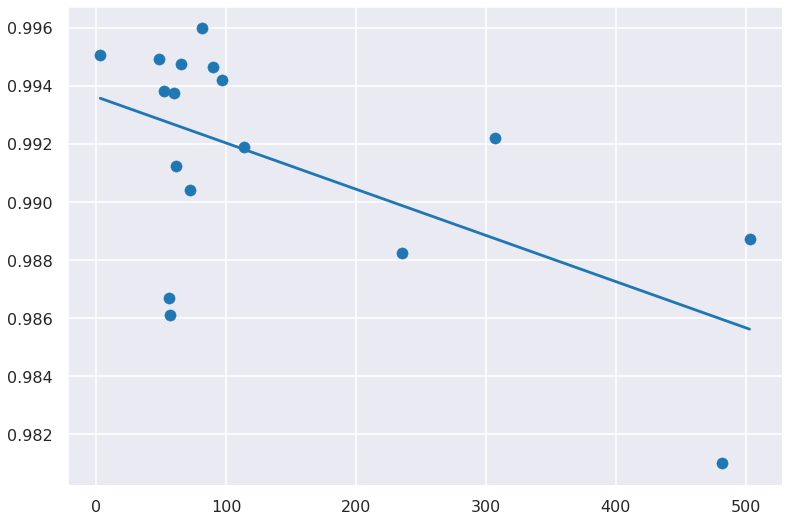

In [17]:
X = Comparison_Frame['missing_values']
Y = Comparison_Frame['Rsq']
a, b = best_fit(X,Y)

plt.scatter(X,Y)
yfit = [a + b * xi for xi in X]
plt.plot(X, yfit)

In [18]:
all_results

[{'feature_prune': False,
  'hyperparameter_tune': False,
  'hyperparameters_userspecified': {'default': {'CAT': [{}],
    'GBM': [{}, {'AG_args': {'name_suffix': 'XT'}, 'extra_trees': True}],
    'KNN': [{'AG_args': {'name_suffix': 'Unif'}, 'weights': 'uniform'},
     {'AG_args': {'name_suffix': 'Dist'}, 'weights': 'distance'}],
    'NN': [{}],
    'RF': [{'AG_args': {'name_suffix': 'MSE', 'problem_types': ['regression']},
      'criterion': 'mse'}],
    'XT': [{'AG_args': {'name_suffix': 'MSE', 'problem_types': ['regression']},
      'criterion': 'mse'}],
    'custom': [{'AG_args': {'disable_in_hpo': True,
       'model_type': 'GBM',
       'name_suffix': 'Custom'},
      'boosting_type': 'gbdt',
      'feature_fraction': 0.9,
      'learning_rate': 0.03,
      'min_data_in_leaf': 5,
      'num_boost_round': 10000,
      'num_leaves': 128,
      'num_threads': -1,
      'objective': 'regression',
      'seed_value': 0,
      'two_round': True,
      'verbose': -1}]}},
  'leaderboard'